In [1]:
# Import libraries and modules
import requests
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict

import taxi_cab as tc

Load and investigate data

In [2]:
# Load data from website and into pandas dataframe
data_extract = tc.DataExtract()
file_name = data_extract.download_data(2016, 12)
df = data_extract.load_data(file_name)

In [3]:
df.dtypes

VendorID                          int64
lpep_pickup_datetime     datetime64[ns]
lpep_dropoff_datetime    datetime64[ns]
store_and_fwd_flag               object
RatecodeID                        int64
PULocationID                      int64
DOLocationID                      int64
passenger_count                   int64
trip_distance                   float64
fare_amount                     float64
extra                           float64
mta_tax                         float64
tip_amount                      float64
tolls_amount                    float64
ehail_fee                       float64
improvement_surcharge           float64
total_amount                    float64
payment_type                      int64
trip_type                         int64
congestion_surcharge            float64
dtype: object

<AxesSubplot:>

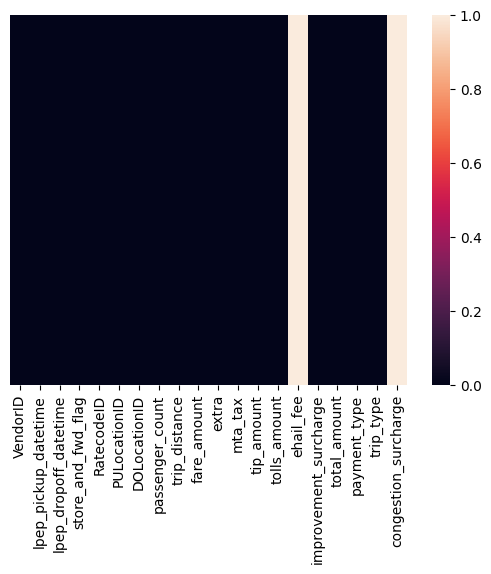

In [4]:
sns.heatmap(df.isnull(), yticklabels=False)

Ehail fee and congestion surcharge appear contain only null values. Otherwise, other columns do not appear to have missing values.

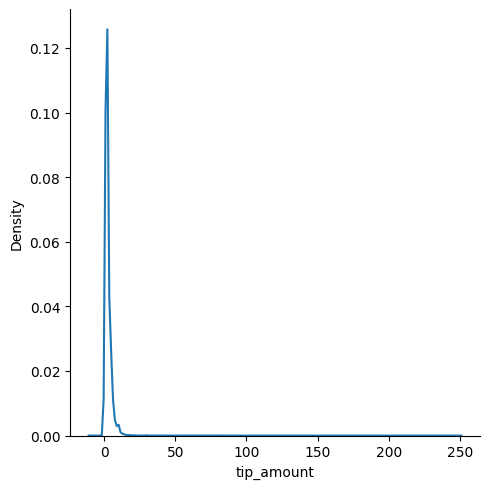

In [5]:
sns.displot(df, x='tip_amount', kind='kde')

There are some tip values less than zero. These could be valid or should not be there. This requires further digging.

Data Distribution

In [6]:
# Add features trip duration, pickup hour, and day of week
df = tc.FeatureEngineering().add_new_features(df)

In [7]:
df.describe().apply(lambda s: s.apply('{0:.5f}'.format))

,VendorID,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,trip_duration,pickup_hour
count,1224158.00000,1224158.00000,1224158.00000,1224158.00000,1224158.00000,1224158.00000,1224158.00000,1224158.00000,1224158.00000,1224158.00000,1224158.00000,0.00000,1224158.00000,1224158.00000,1224158.00000,1224158.00000,0.00000,1224158.00000,1224158.00000
mean,1.79928,1.08508,113.17287,129.08622,1.36245,2.61818,11.59368,0.36296,0.48726,1.12879,0.09457,nan,0.29252,13.99902,1.53486,1.01972,nan,20.66782,13.94833
std,0.40054,0.56602,76.28387,77.23367,1.03692,2.80616,9.79350,0.39016,0.08517,2.21631,0.88085,nan,0.05073,11.12872,0.52410,0.13904,nan,105.12575,6.53807
min,1.00000,1.00000,1.00000,1.00000,0.00000,0.00000,-499.00000,-4.50000,-0.50000,-10.56000,-8.54000,nan,-0.30000,-499.00000,1.00000,1.00000,nan,0.00000,0.00000
25%,2.00000,1.00000,49.00000,61.00000,1.00000,0.98000,6.00000,0.00000,0.50000,0.00000,0.00000,nan,0.30000,7.80000,1.00000,1.00000,nan,5.73333,10.00000
50%,2.00000,1.00000,83.00000,129.00000,1.00000,1.70000,9.00000,0.50000,0.50000,0.00000,0.00000,nan,0.30000,10.80000,2.00000,1.00000,nan,9.63333,15.00000
75%,2.00000,1.00000,173.00000,193.00000,1.00000,3.20000,14.00000,0.50000,0.50000,1.86000,0.00000,nan,0.30000,16.56000,2.00000,1.00000,nan,16.05000,19.00000
max,2.00000,6.00000,265.00000,265.00000,9.00000,147.50000,1007.00000,4.50000,0.50000,250.70000,297.98000,nan,0.30000,1008.30000,5.00000,2.00000,nan,2487.90000,23.00000


Data appears to be somewhat of a mess with extreme values, values with 0s, and negative values. The extreme values could throw off models. There are also negative values, for example the field fare_amount has a value of -499. It is unclear how a negative fare amount could occur so these values may be invalid. Also, there are a lot of 0 values which potentially could not be there intentially. 

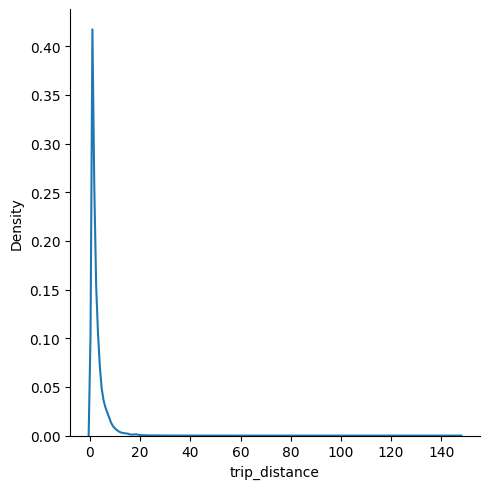

In [8]:
sns.displot(df, x='trip_distance', kind='kde')

Trip distance is heavily skewed to the left. The distribution excluding the outliers is difficult to tell based on this graph.

Text(0.5, 9.444444444444438, 'log_trip_duration')

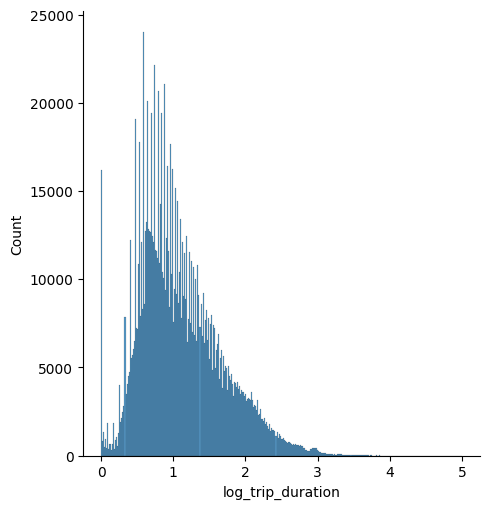

In [9]:
sns.displot(x=np.log(df['trip_distance'].values + 1))
plt.xlabel('log_trip_duration')

Calculating the log of trip distance indicates that the data is reasonably normally distributed. This will be especially true if the outliers are removed.

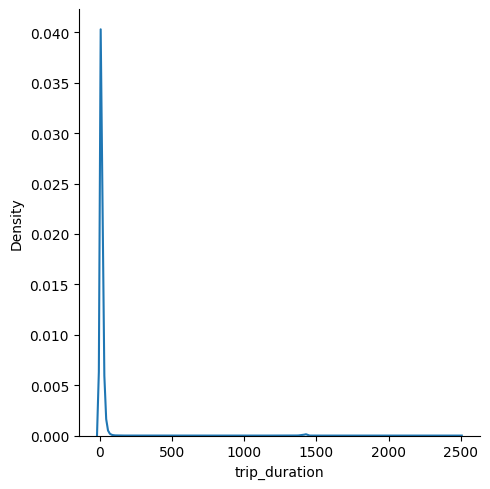

In [10]:
sns.displot(df, x='trip_duration', kind='kde')

There are some extreme values or outliers in the trip duration data as well.

Text(0.5, 9.444444444444438, 'log_trip_duration')

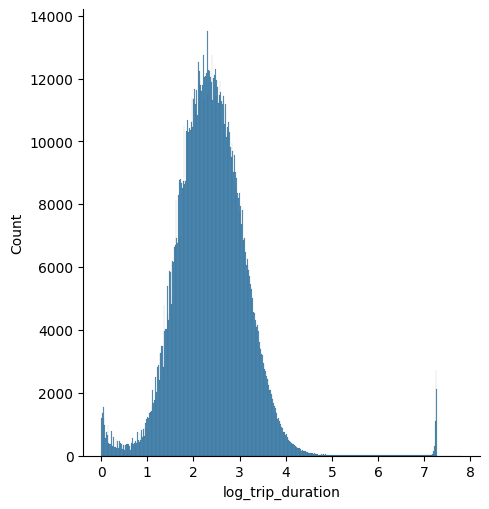

In [11]:
sns.displot(x=np.log(df['trip_duration'].values + 1))
plt.xlabel('log_trip_duration')

<AxesSubplot:>

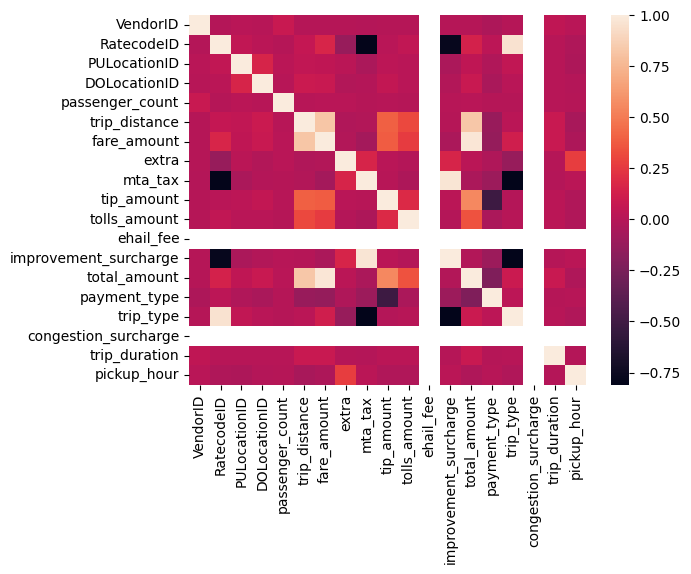

In [12]:
sns.heatmap(df.corr())

Most fields are not correlated with each other however a few do because of their relationship. Tips are typically based on the fare and both contribute to the total amount. For predictive modeling, optimizing for higher fare amounts may not be ideal.

Better Tips

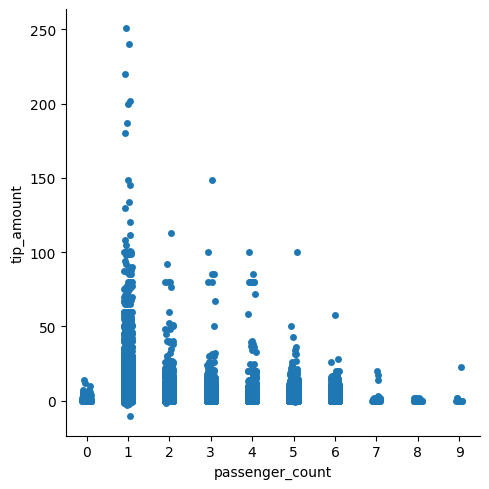

In [13]:
sns.catplot(data=df, x='passenger_count', y='tip_amount')

It is interesting that 1 passenger has the highest tips. Other factors may affect this if for example typically 1 passenger has longer rides or car pooling is included. Further understanding is needed to determine the predictiveness of this feature.

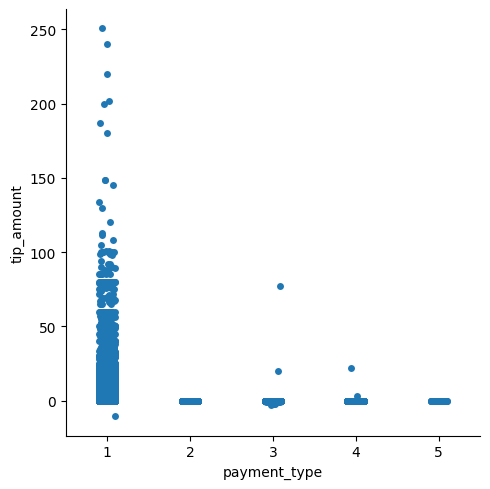

In [14]:
sns.catplot(data=df, x='payment_type', y='tip_amount')

<AxesSubplot:xlabel='trip_distance', ylabel='tip_amount'>

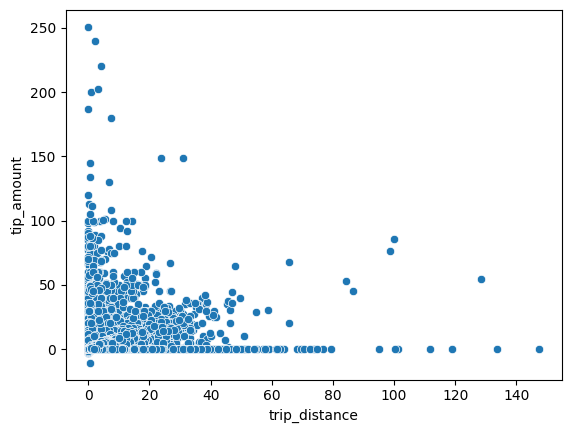

In [15]:
sns.scatterplot(data=df, x='trip_distance', y='tip_amount')

I would have expected a stronger correlation between trip distance and tip amount but it does not appear to be the. This may be due to the fact this data is from a metropolitan city where distance does not always associate with higher costs and therefore not as high tips.

<AxesSubplot:xlabel='trip_duration', ylabel='tip_amount'>

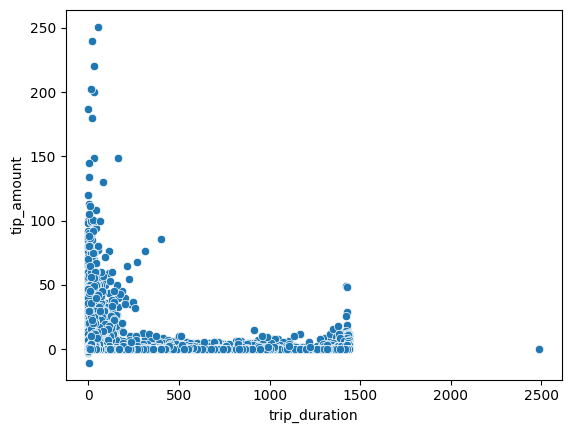

In [16]:
sns.scatterplot(data=df, x='trip_duration', y='tip_amount')

This shows a similar relationship with trip_distance. Other factors must be at play that determine tip amount.

Interesting statistics based on hour

In [17]:
# Set pickup hour field
df_group_hour = tc.FeatureEngineering().group_by_hour(df)

<AxesSubplot:xlabel='pickup_hour', ylabel='trip_distance'>

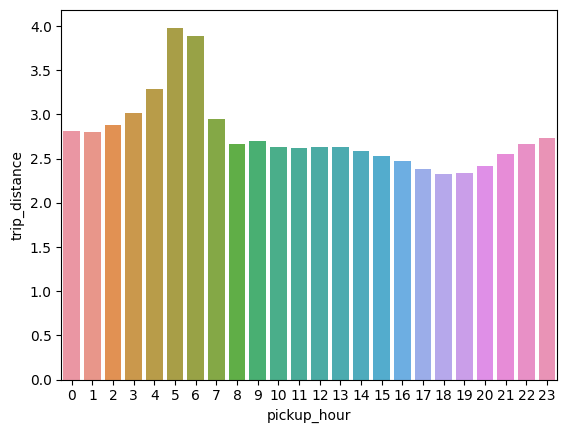

In [18]:
sns.barplot(data=df_group_hour, x='pickup_hour', y='trip_distance')

Clearly there is a spike in morning hours however I would have expected a larger spike and also in the evening when people take cabs after work but based on the data it does not appear to be so.

<AxesSubplot:xlabel='pickup_hour', ylabel='total_amount'>

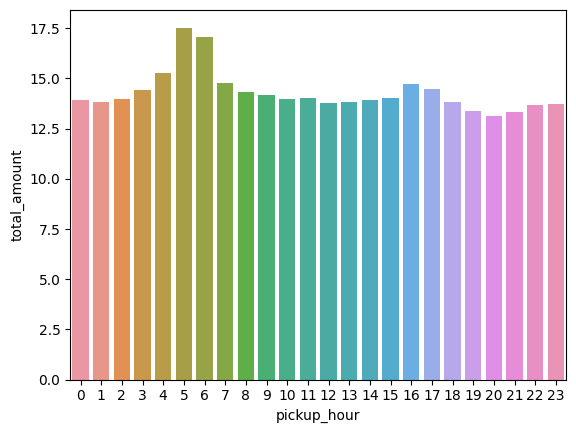

In [19]:
sns.barplot(data=df_group_hour, x='pickup_hour', y='total_amount')

<AxesSubplot:xlabel='pickup_hour', ylabel='tip_amount'>

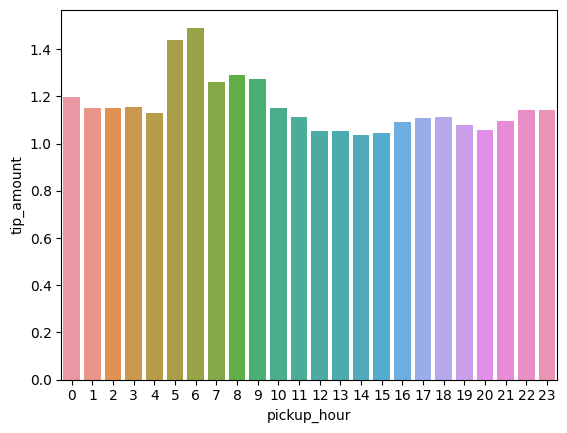

In [20]:
sns.barplot(data=df_group_hour, x='pickup_hour', y='tip_amount')

These charts show similar relationships with activity and hour of the day.

Evaluating tips

Feature Engineering

In [21]:
# Generate X and y data and filter for specific fields
fields_to_use = ['PULocationID', 'DOLocationID', 'store_and_fwd_flag', 'RatecodeID', 'passenger_count', 'trip_distance', 'fare_amount', 'extra', 'mta_tax', 'tolls_amount', 'improvement_surcharge', 'total_amount', 'payment_type', 'trip_type', 'tip_amount', 'pickup_hour', 'day_of_week']
feat_eng = tc.FeatureEngineering()
df_feat = df.loc[:, fields_to_use]
X_data, y_data = feat_eng.get_x_y(df_feat)

<AxesSubplot:>

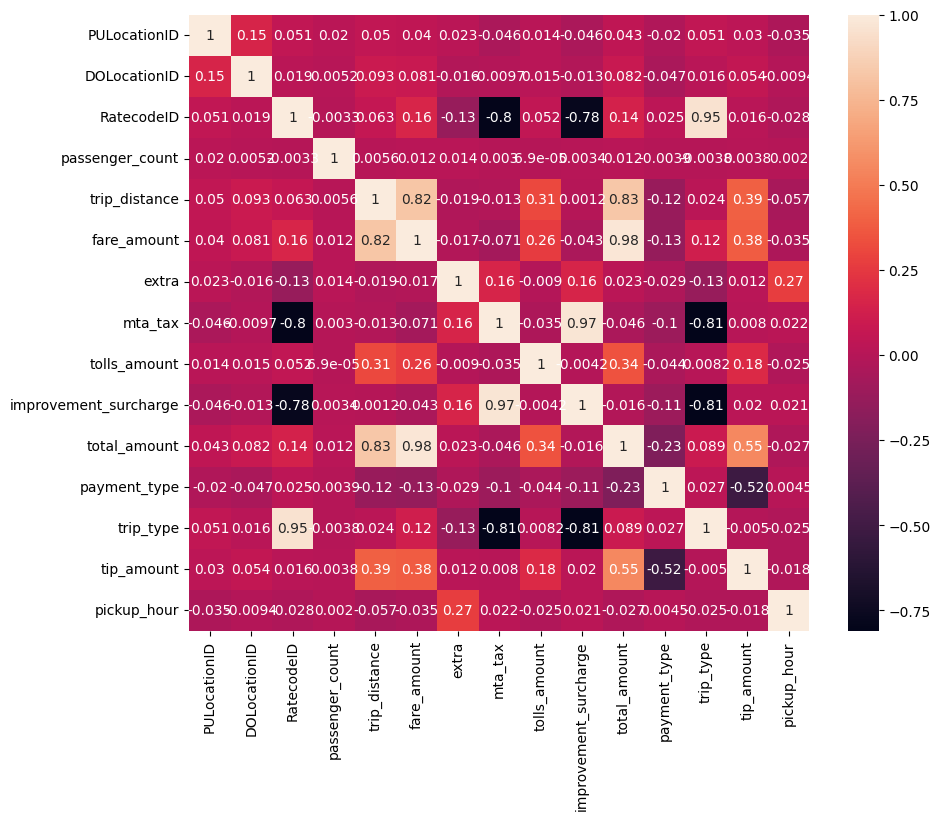

In [22]:
plt.figure(figsize=[10,8])
sns.heatmap(df_feat.corr(), annot=True)

A similar heatmap as before, this shows high correlation with a few variables that could throw off models.

c:\Users\salit\code\vianai_test\taxi_cab.py:149: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  clf.fit(self.X_data, self.y_data)
c:\Users\salit\code\vianai\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
c:\Users\salit\code\vianai\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.913e+04, tolerance: 6.013e+02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


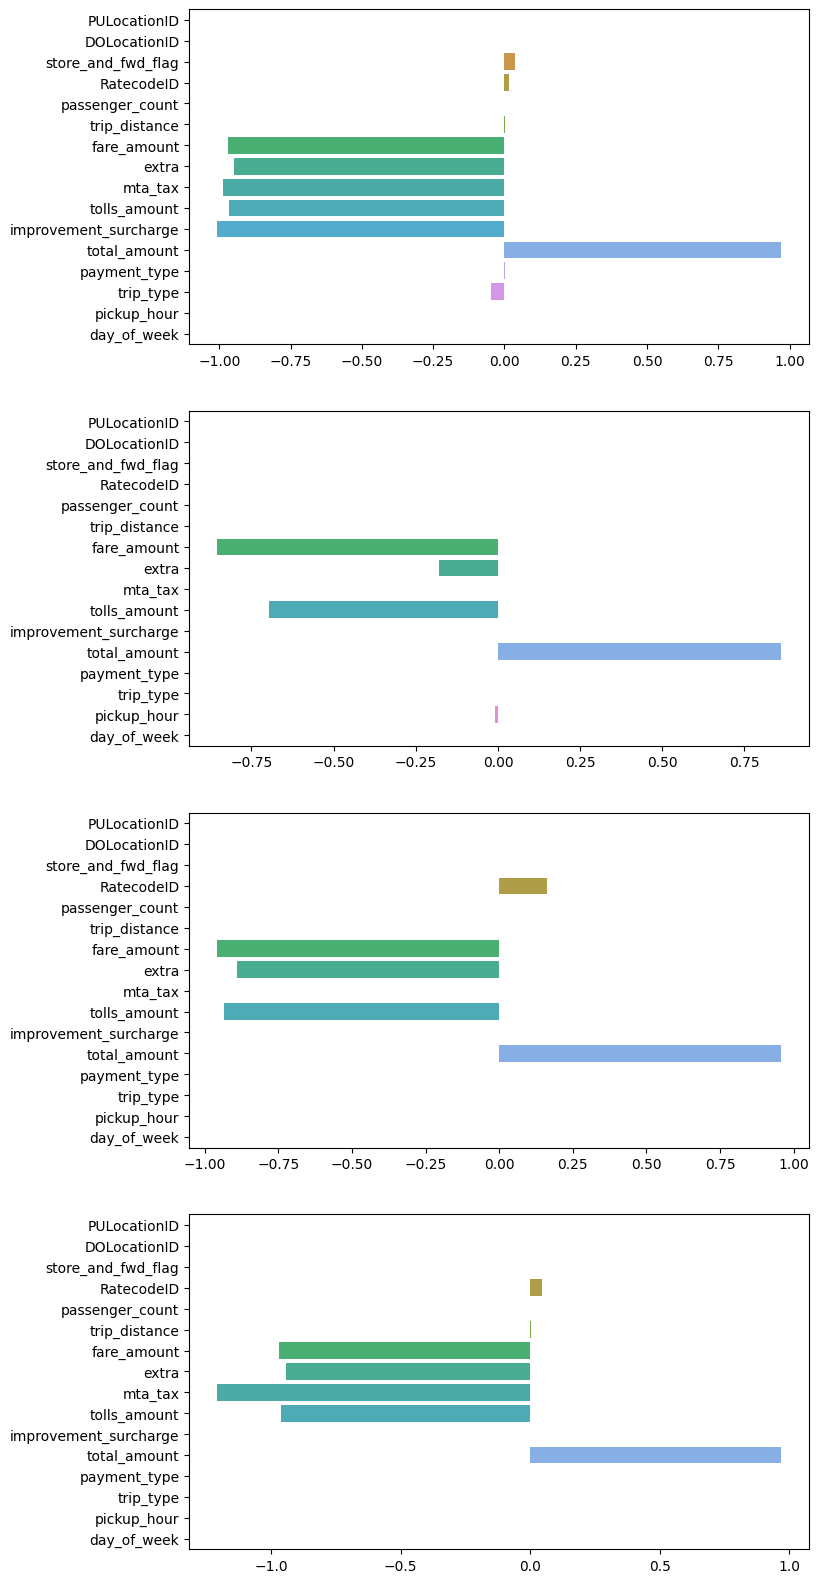

In [23]:
# Use lasso regression on various alpha levels to observe features that could be the most predictive
feat_select = tc.FeatureSelection(X_data, y_data)
feat_select.lasso_feature_selection()

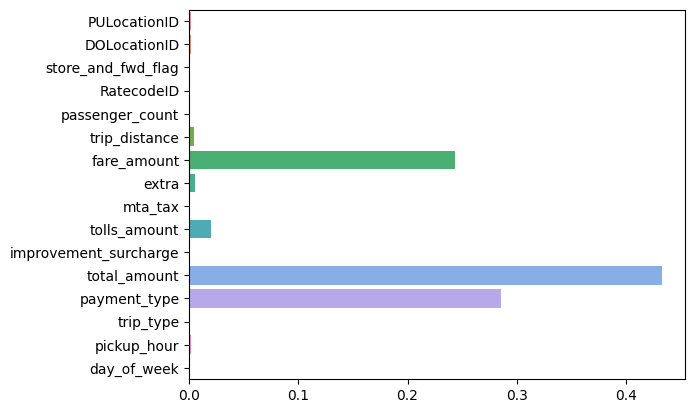

In [24]:
feat_select.random_forest_feature_selection()

These models are easily thrown off by highly correlated variables. More feature engineering is required to develop better predictive models. Some features like payment type are most likely not possible to be changed by a taxi/cab driver.

In [25]:
# Train models to predict tip amount
def calc_results(X_data, y_data, run_neural_networks=False):
    results = {}
    # Split data and standardize using z-scores
    data = feat_eng.split_data(X_data, y_data)
    data = feat_eng.standardize_data(data)
    models = tc.Models()

    # Baseline results
    results['basic_lr'] = models.get_linear_reg_results(data)
    results['basic_rf'] = models.get_random_forest_reg_results(data)
    if run_neural_networks:
        results['basic_nn'] = tc.get_neural_network_results(data)

    # Log y results
    log_data = data.copy()
    log_data['y_train'] = np.log(data.get("y_train")) + 1
    log_data['y_train'] = log_data['y_train'].replace(-np.Inf, 0)
    log_data['y_train'] = log_data['y_train'].fillna(0)
    results['log_lr'] = models.get_linear_reg_results(log_data)
    results['log_rf'] = models.get_random_forest_reg_results(log_data)
    if run_neural_networks:
        results['log_nn'] = tc.get_neural_network_results(log_data)
    del log_data

    # Remove outlier results
    out_X_data, out_y_data = feat_eng.remove_outliers(X_data, y_data, "trip_distance")
    out_data = data.copy()
    out_data['X_train'] = out_X_data
    out_data['y_train'] = out_y_data
    results['rem_out_lr'] = models.get_linear_reg_results(out_data)
    results['rem_out_rf'] = models.get_random_forest_reg_results(out_data)
    if run_neural_networks:
        results['rem_out_nn'] = tc.get_neural_network_results(out_data)
    del out_data

    # Remove correlated variables
    fields_to_use = ['PULocationID', 'DOLocationID', 'store_and_fwd_flag', 'RatecodeID', 'passenger_count', 'extra', 'mta_tax', 'tolls_amount', 'improvement_surcharge', 'payment_type', 'trip_type', 'pickup_hour', 'day_of_week']
    corr_vars = data.copy()
    corr_vars['X_train'] = corr_vars['X_train'].loc[:, fields_to_use]
    corr_vars['X_val'] = corr_vars['X_val'].loc[:, fields_to_use]
    corr_vars['X_test'] = corr_vars['X_test'].loc[:, fields_to_use]
    results['rem_corr_vars_lr'] = models.get_linear_reg_results(corr_vars)
    results['rem_corr_vars_rf'] = models.get_random_forest_reg_results(corr_vars)
    if run_neural_networks:
        results['rem_corr_vars_nn'] = tc.get_neural_network_results(corr_vars)
    del corr_vars

    df_results = pd.DataFrame.from_dict(results, orient='index')
    df_results.index.name = "test_name"
    df_results.to_csv('taxi_cab_results.csv')
    return df_results

In [ ]:
results = calc_results(X_data, y_data, run_neural_networks=False)

In [ ]:
results

,train,val,test
test_name,,,
basic_lr,0.080644,0.077611,0.081226
basic_rf,0.016568,0.058557,0.091429
basic_nn,0.205438,0.217067,0.210933
log_lr,0.193039,2.206764,2.383723
log_rf,0.000964,2.241130,2.536429
log_nn,0.052780,2.306805,2.660982
rem_out_lr,0.054822,12.728883,12.481623
rem_out_rf,0.007516,5.785791,6.048552
rem_out_nn,0.201897,7.112075,8.035919


Several experiments were run using three models. The three models used were linear regression, random forest, and a 3 layer neural network to predict tip amount. Four tests were run to try to develop the most predictive model. Preprocessing on the data was only applied to the training set. 

The four tests were:
1. No additional data preprocessing
2. Log target data to better handle outliers
3. Use simple logic to remove some outliers
4. Remove highly correlated variables to try to determine factors that should actually be recommended.

Based off of preliminary results, no additional preprocessing with linear regression produced the best results. Further digging would be needed to understand why additional preprocessing and more sophisticated models did not produce better results. The data may not be complex enough where simple models perform best. There does not appear to be overfitting in the data so data leakage may be present. Surprisingly, the neural networks did not overfit the data too much. More training or understanding of the results would be needed to know why.

Anomaly Detection

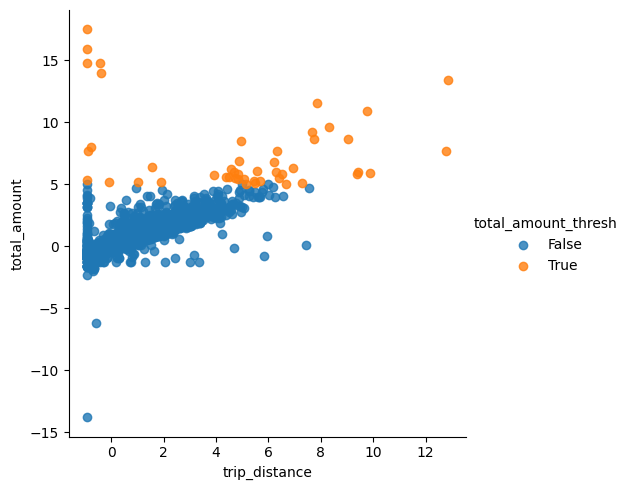

In [ ]:
# Use isolation forests and z-score thresholds to determine outliers. Sample data for better visualization.
X_train = X_data.copy()
X_train['annomaly'] = tc.Models(X_train).get_isolation_forest_preds()
threshold = 5
X_train['total_amount_thresh'] = X_train['total_amount'] > threshold
sns.lmplot(x='trip_distance', y='total_amount', data=X_train.sample(10000), hue='total_amount_thresh', fit_reg=False)

Using a z-score threshold of 5 of the total amount field did a moderate job at predicting outliers. When looking at total amount and trip distance, there is a clear dividing line for where these values occur. This is not unexpected as these variables are highly correlated.

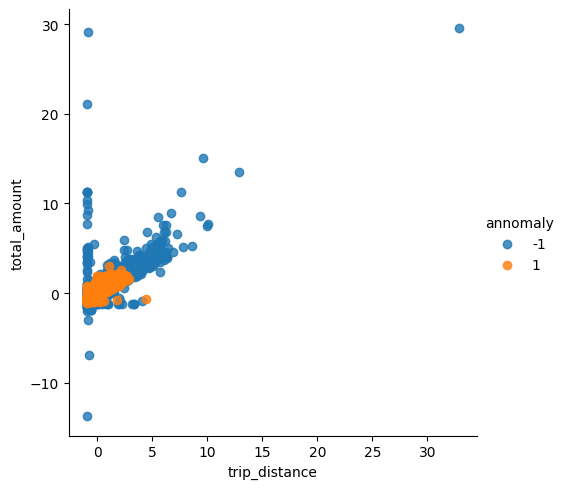

In [ ]:
sns.lmplot(x='trip_distance', y='total_amount', data=X_train.sample(10000), hue='annomaly', fit_reg=False)

Using isolation forest models does a moderate job with separating the outliers. However, it has too high of sensitivity to predicting outliers. Further tuning would be required to better separate and identify the outliers